# __1. Import thư viện__

In [1]:
# Import thư viện
import pandas as pd
import os

import json
import requests

import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed

from langdetect import detect, LangDetectException

from datetime import datetime
from nltk.corpus import stopwords
from tqdm import tqdm
tqdm.pandas()
import re
from collections import Counter

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# __2. Các hàm hỗ trợ__

## Hàm đọc file json

In [2]:
class FileReader:
    def __init__(self, file_path, row):
        with open(file_path, 'r') as file:
            data = json.load(file)
            self.ppid = data['paper_id']
            self.body_text = '\n'.join(dt['text'] for dt in data['body_text'])
            self.abstract = '\n'.join(dt['text'] for dt in data.get('abstract', [])) or row['abstract']
            self.title = data.get('metadata', {}).get('title', None)
            self.publish_time = row['publish_time']
            self.doi = row['doi']

## Hàm xử lý dữ liệu json

In [3]:
def pdf_df(df: pd.DataFrame) -> pd.DataFrame:
    filtered_df =  df[(df['sha'].apply(lambda x: isinstance(x, str))) & (df['pdf_json_files'].apply(lambda x: isinstance(x, str)))]
    expanded_df = filtered_df.assign(
        sha = filtered_df['sha'].str.split('; '),
        pdf_json_files = filtered_df['pdf_json_files'].str.split('; ')
    ).explode(['sha', 'pdf_json_files']).reset_index(drop=True)
    return expanded_df

def process_row(row):
    dict_ = {'paper_id': [], 'title': [], 'abstract': [], 'body_text': [], 'publish_time': [], 'doi': []}
    pdf_files = row['pdf_json_files'].split('; ')
    for file in pdf_files:
        if not os.path.exists(file):
            continue
        data = FileReader(file, row)
        dict_['paper_id'].append(data.ppid)
        dict_['title'].append(data.title)
        dict_['abstract'].append(data.abstract)
        dict_['body_text'].append(data.body_text)
        dict_['publish_time'].append(data.publish_time)
        dict_['doi'].append(data.doi)
    return dict_

def pdf_jsons_to_df(df: pd.DataFrame) -> pd.DataFrame:
    df = pdf_df(df=df)
    df.drop_duplicates(inplace=True)
    all_dicts = []

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_row, row) for _, row in df.iterrows()]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing rows"):
            all_dicts.append(future.result())

    # Combine results into a single DataFrame
    dict_ = {
        'paper_id': [], 'title': [], 'abstract': [], 'body_text': [], 'publish_time': [], 'doi': []
    }
    for d in all_dicts:
        for key in dict_:
            dict_[key].extend(d[key])

    df_covid = pd.DataFrame(dict_, columns=['paper_id', 'title', 'abstract', 'body_text', 'publish_time', 'doi'])
    return df_covid

### Hàm xử lý dữ liệu pmc_json

In [4]:
def pmc_df(df: pd.DataFrame) -> pd.DataFrame:
    return df[(df['sha'].apply(lambda x: not isinstance(x, str))) & (df['pmc_json_files'].apply(lambda x: isinstance(x, str)))]

def process_pmc_row(row):
    dict_ = {'paper_id': [], 'title': [], 'abstract': [], 'body_text': [], 'publish_time': [], 'doi': []}
    pmc_files = row['pmc_json_files'].split('; ')
    for file in pmc_files:
        if not os.path.exists(file):
            continue
        data = FileReader(file, row)
        dict_['paper_id'].append(data.ppid)
        dict_['title'].append(data.title)
        dict_['abstract'].append(data.abstract)
        dict_['body_text'].append(data.body_text)
        dict_['publish_time'].append(data.publish_time)
        dict_['doi'].append(data.doi)
    return dict_

def pmc_jsons_to_df(df: pd.DataFrame) -> pd.DataFrame:
    df = pmc_df(df=df)
    df.drop_duplicates(inplace=True)
    all_dicts = []

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_pmc_row, row) for _, row in df.iterrows()]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing PMC rows"):
            all_dicts.append(future.result())

    # Combine results into a single DataFrame
    dict_ = {
        'paper_id': [], 'title': [], 'abstract': [], 'body_text': [], 'publish_time': [], 'doi': []
    }
    for d in all_dicts:
        for key in dict_:
            dict_[key].extend(d[key])

    df_covid = pd.DataFrame(dict_, columns=['paper_id', 'title', 'abstract', 'body_text', 'publish_time', 'doi'])
    return df_covid

## Hàm tìm ngôn ngữ của bài báo

In [5]:
# Tối ưu hóa hàm detect_language
def detect_language(row):
    body_text = row['body_text']
    if not isinstance(body_text, str) or len(body_text.strip()) == 0: 
        return 'unknown'  # Tránh xử lý những chuỗi rỗng
    body_text = body_text[:500]  # Giới hạn số ký tự để xử lý nhanh hơn
    try:
        return detect(body_text)  # Phân tích ngôn ngữ từ 5000 ký tự đầu tiên
    except LangDetectException:
        return 'unknown'

# Hàm xử lý song song với concurrent.futures
def process_languages_parallel(df):
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        # Sử dụng map để chạy song song hàm detect_language trên mỗi dòng
        results = list(tqdm(executor.map(detect_language, [row for _, row in df.iterrows()]), total=len(df)))
    # Gán kết quả vào cột 'language' trong dataframe
    df['language'] = results
    return df

## Hàm truy cập vào doi

In [6]:
def requests_doi(doi):
    url = f"https://api.crossref.org/works/{doi}"
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            return response.json()
        return None
    except requests.RequestException:
        return None

def title_doi(doi):
    data = requests_doi(doi)
    if data:
        if 'message' in data:
            if 'title' in data['message']:
                return data['message']['title'][0]
    return None


def title_doi_parallel(df):
    with ThreadPoolExecutor(max_workers=5) as executor:
        # Sử dụng map để chạy song song và theo dõi tiến độ bằng tqdm
        results = list(tqdm(executor.map(title_doi, df['doi']), total=len(df)))
    # Gán kết quả vào cột 'status_api' trong dataframe
    df['title_doi'] = results
    return df

def check_doi(doi):
    url = f"https://api.crossref.org/works/{doi}"
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            return True
        return False
    except requests.RequestException:
        return False

def check_doi_parallel(df):
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        # Sử dụng map để chạy song song và theo dõi tiến độ bằng tqdm
        results = list(tqdm(executor.map(check_doi, df['doi']), total=len(df), desc="Checking DOIs"))
    # Gán kết quả vào cột 'status_api' trong dataframe
    df['status_api'] = results
    return df

## Hàm tính số lượng từ khoá của từng bài báo

In [15]:
# Hàm làm sạch văn bản
def clean_text(text):
    if not isinstance(text, str):  # Kiểm tra nếu không phải chuỗi
        return []
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Loại bỏ dấu câu
    text = re.sub(r'\d+', '', text)      # Loại bỏ số
    return text.split()                  # Tách thành danh sách từ

# Hàm đếm số từ khóa trong một bài báo
def count_keywords_in_text(text, keywords):
    text_words = clean_text(text)  # Làm sạch và tách từ
    return {key: text_words.count(key) for key in keywords}

# Hàm chính: xử lý song song theo nhóm 50 dòng
def count_keywords_parallel(df, keywords):
    def process_row(text):
        return count_keywords_in_text(text, keywords)
    with ThreadPoolExecutor(max_workers=10) as executor:
        all_results = list(tqdm(executor.map(process_row, df['body_text']), total=len(df), desc="Counting keywords"))
    for key in keywords:
        df[key] = [res[key] for res in all_results]
    return df

# __3. Lọc dữ liệu__

## __Đọc dữ liệu__

In [8]:
df = pd.read_csv('metadata.csv')
df.drop(['cord_uid', 'source_x', 'pmcid', 'pubmed_id', 'license', 'authors', 'journal', 'mag_id', 'who_covidence_id', 'arxiv_id', 'url', 's2_id'], axis=1, inplace=True)

C:\Users\dnson\AppData\Local\Temp\ipykernel_1696\3694816371.py:1: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('metadata.csv')


In [11]:
df.shape

(1056660, 7)

In [9]:
df.isnull().sum()

sha               682894
title                503
doi               399880
abstract          235544
publish_time        1814
pdf_json_files    682894
pmc_json_files    740918
dtype: int64

In [10]:
df.duplicated().sum()

np.int64(62604)

Vì dịch covid theo who chỉ có timeline từ 31-12-2019 đến 2022

In [6]:
df = df[df['publish_time'].apply(lambda x: isinstance(x, str) and len(x) == 10)]
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df = df[df['publish_time'].between('2020-01-01', '2022-12-31') | (df['publish_time'] == '2019-12-31')]

### PDF

In [7]:
df_pdf_covid = pdf_jsons_to_df(df)

Processing rows: 100%|██████████| 352356/352356 [15:06<00:00, 388.61it/s] 


### PMC

In [12]:
df_pmc_covid = pmc_jsons_to_df(df)

C:\Users\dnson\AppData\Local\Temp\ipykernel_5852\2140501006.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)
Processing PMC rows: 100%|██████████| 14677/14677 [00:27<00:00, 534.09it/s]


### Gộp pdf và pmc thành covid_data_raw

In [16]:
covid_data_raw = pd.concat([df_pdf_covid, df_pmc_covid], ignore_index=True)
covid_data_raw = covid_data_raw.drop_duplicates()

### Chuyển từ df sang csv để lưu

In [19]:
covid_data_raw.to_csv('./CSV/covid_data_raw.csv', index=False, encoding='utf-8')

In [3]:
covid_data_raw = pd.read_csv('./CSV/covid_data_raw.csv')

## __Làm sạch dữ liệu__

### Lọc các bài báo là tiếng Anh

In [5]:
df_en = process_languages_parallel(covid_data_raw)

100%|██████████| 367001/367001 [16:04<00:00, 380.70it/s]  


In [8]:
df_en = df_en[df_en['language'] == 'en']

Dataframe English

In [10]:
df_en.to_csv('./CSV/data_english.csv', index=False)

In [11]:
df_en.isnull().sum()

paper_id            0
title           39680
abstract        40614
body_text           0
publish_time        0
doi             11493
language            0
dtype: int64

### Lọc các bài báo chính thống (bài báo có doi)

In [14]:
df_en = df_en[df_en['doi'].apply(lambda x: isinstance(x, str))]
df_en.drop('language', axis=1, inplace=True)
df_en

,paper_id,title,abstract,body_text,publish_time,doi
0,878235c11286bd3f128c970c198721f5e6d2853c,NaN,NaN,The December 2020 issue of Academic Psychiatry...,2020-10-30,10.1007/s40596-020-01357-z
4370,dbeef041d98f24a132d0b6056c5c8f6676cde3ce,"Clinical Medicine Subcutaneous, Paracardiac, a...","Adipose tissue, in particular epicardial adipo...",Epicardial adipose tissue is a metabolically a...,2021-02-12,10.3390/jcm10040735
4428,7109a206b02f37f65e73371d0dd38dc06478ef8f,molecules Efficient Regioselective Synthesis o...,"Citation: Potapov, V.A.; Ishigeev, R.S.; Amoso...",The quinoline ring continues to occupy an impo...,2021-02-20,10.3390/molecules26041116
4432,33f289415db6fbb99204b8fefba9c9d6334a0721,Distributed Architecture for Unmanned Vehicle ...,"Citation: Ramos, J.; Ribeiro, R.; Safadinho, D...",The evolution of the technology is raising new...,2021-02-20,10.3390/s21041477
4436,00767c9591083b810350e0355530511685bbc78d,Circulation,NaN,"A s we write these words, the United States is...",2021-03-02,10.1161/circulationaha.120.053439
...,...,...,...,...,...,...
366996,PMC7773112,Recent discovery and development on SARS-CoV-2...,The origin and spread of current novel coronav...,A cluster of patients with pneumonia of unknow...,2020-10-30,10.4103/jfmpc.jfmpc_851_20
366997,PMC7901595,Digital Pathology During the COVID-19 Outbreak...,BACKGROUND: Transition to digital pathology us...,Digital pathology (DP) intends to use computer...,2021-02-22,10.2196/24266
366998,PMC9008685,Tozinameran,NaN,\nAuthor Information\nAn event is serious (bas...,2022-04-16,10.1007/s40278-022-13539-4
366999,PMC9051801,Tozinameran/prednisone,NaN,\nAuthor Information\nAn event is serious (bas...,2022-04-30,10.1007/s40278-022-14373-1


### Lọc các bài báo theo độ dài body và độ dài abstract

In [16]:
df_en.isnull().sum()

paper_id            0
title           39331
abstract        40487
body_text           0
publish_time        0
doi                 0
dtype: int64

In [22]:
df_en['length_body'] = df_en['body_text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
df_en['length_abstract'] = df_en['abstract'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
df_en = df_en[df_en['length_body'] > df_en['length_abstract']]
df_en

,paper_id,title,abstract,body_text,publish_time,doi,length_body,length_abstract
0,878235c11286bd3f128c970c198721f5e6d2853c,NaN,NaN,The December 2020 issue of Academic Psychiatry...,2020-10-30,10.1007/s40596-020-01357-z,576,0
4370,dbeef041d98f24a132d0b6056c5c8f6676cde3ce,"Clinical Medicine Subcutaneous, Paracardiac, a...","Adipose tissue, in particular epicardial adipo...",Epicardial adipose tissue is a metabolically a...,2021-02-12,10.3390/jcm10040735,2869,222
4428,7109a206b02f37f65e73371d0dd38dc06478ef8f,molecules Efficient Regioselective Synthesis o...,"Citation: Potapov, V.A.; Ishigeev, R.S.; Amoso...",The quinoline ring continues to occupy an impo...,2021-02-20,10.3390/molecules26041116,2248,27
4432,33f289415db6fbb99204b8fefba9c9d6334a0721,Distributed Architecture for Unmanned Vehicle ...,"Citation: Ramos, J.; Ribeiro, R.; Safadinho, D...",The evolution of the technology is raising new...,2021-02-20,10.3390/s21041477,15971,20
4436,00767c9591083b810350e0355530511685bbc78d,Circulation,NaN,"A s we write these words, the United States is...",2021-03-02,10.1161/circulationaha.120.053439,1306,0
...,...,...,...,...,...,...,...,...
366996,PMC7773112,Recent discovery and development on SARS-CoV-2...,The origin and spread of current novel coronav...,A cluster of patients with pneumonia of unknow...,2020-10-30,10.4103/jfmpc.jfmpc_851_20,3652,298
366997,PMC7901595,Digital Pathology During the COVID-19 Outbreak...,BACKGROUND: Transition to digital pathology us...,Digital pathology (DP) intends to use computer...,2021-02-22,10.2196/24266,2323,287
366998,PMC9008685,Tozinameran,NaN,\nAuthor Information\nAn event is serious (bas...,2022-04-16,10.1007/s40278-022-13539-4,214,0
366999,PMC9051801,Tozinameran/prednisone,NaN,\nAuthor Information\nAn event is serious (bas...,2022-04-30,10.1007/s40278-022-14373-1,376,0


In [25]:
# Dataframe chua co title theo doi
df_en.to_csv('./CSV/data_english_1.csv', index=False)

### Xử lý thiếu title bằng cách truy cập vào doi

In [27]:
df_en_title = df_en[df_en['title'].apply(lambda x: isinstance(x, str))]
df_en_no_title = df_en[df_en['title'].apply(lambda x: not isinstance(x, str))]

 Xử lý với dataframe không có title

In [34]:
df_en_no_title = check_doi_parallel(df_en_no_title)

Checking DOIs: 100%|██████████| 38621/38621 [1:45:36<00:00,  6.10it/s]  
C:\Users\dnson\AppData\Local\Temp\ipykernel_1020\4186481824.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status_api'] = results


In [38]:
df_en_no_title = df_en_no_title[df_en_no_title['status_api'] == True]

In [40]:
df_en_no_title1 = df_en_no_title.copy()
df_en_no_title1 = title_doi_parallel(df_en_no_title1)

100%|██████████| 38412/38412 [1:44:58<00:00,  6.10it/s]  


In [ ]:
df_en_no_title1['title'] = df_en_no_title1['title'].fillna(df_en_no_title1['title_doi'])

In [ ]:
df_en_no_title1 = df_en_no_title1[df_en_no_title1['title'].apply(lambda x: isinstance(x, str))]
df_en_no_title = df_en_no_title1.copy()

In [53]:
df_en_no_title.drop(['title_doi', 'status_api'], axis=1, inplace=True)
df_en_no_title

,paper_id,title,abstract,body_text,publish_time,doi,length_body,length_abstract
0,878235c11286bd3f128c970c198721f5e6d2853c,In This Issue: December 2020,NaN,The December 2020 issue of Academic Psychiatry...,2020-10-30,10.1007/s40596-020-01357-z,576,0
4438,9eaea87dea40c67b640f730fad9c206149efa060,"World Congress on Osteoporosis, Osteoarthritis...",NaN,characteristics and preferences of the patient...,2021-03-03,10.1007/s00198-020-05695-4,15348,0
4441,656632ff89183d68a4b648638ebccb710c770846,How Healthy Are Health-Related Behaviors in Un...,"Citation: Cena, H.; Porri, D.; De Giuseppe, R....",Adolescence and young adulthood (10-24 years o...,2021-02-19,10.3390/nu13020675,5505,25
4457,c05eb529548858c129aa4c04a549b2f6fc77b9bb,Demographic Characteristics of Participants in...,NaN,We identified all novel vaccine products licen...,2021-03-03,10.1007/s11606-021-06670-3,821,0
4463,c1e02353b109c68eec4fd68fa08693374cca5bb9,hiPSCs for predictive modelling of neurodegene...,Human induced pluripotent stem cells (hiPSCs) ...,Cellular reprogramming is a term that encompas...,2021-03-03,10.1038/s41582-021-00465-0,7229,163
...,...,...,...,...,...,...,...,...
352255,7ecbd7671283fa2c0adea0e94550c98d244bf903,COVID-19-Related Loneliness and Psychiatric Sy...,OBJECTIVES: The study examined whether subject...,In response to the Coronavirus disease 2019 (C...,2020-05-27,10.1016/j.jagp.2020.05.018,1435,150
352268,23d86d693951eb3161bce8d671aee3eaacaf7c67,Home Sick with Coronavirus Symptoms: a Nationa...,NaN,Reports from hospitals and locales 1 have high...,2020-09-10,10.1007/s11606-020-06159-5,970,0
352274,b255f4993abde42cc1ba60587e4554bcddbfcd1a,COVID-19 in 2 Persons with Mild Upper Respirat...,We describe 2 cases of coronavirus disease in ...,"shopping space, and floor 7 contains shopping ...",2020-06-03,10.3201/eid2606.200452,1591,50
352287,20f7d192985e71c78a37996490768b8a43d7c61b,Accelerated Critical Therapy Now in the Emerge...,Evaluate the impact of an emergency department...,"From 1975 to 2015, the number of hospital beds...",2022-03-16,10.1097/cce.0000000000000660,2934,305


In [65]:
df_en = pd.concat([df_en_title, df_en_no_title], ignore_index=True)
df_en

,paper_id,title,abstract,body_text,publish_time,doi,length_body,length_abstract
0,dbeef041d98f24a132d0b6056c5c8f6676cde3ce,"Clinical Medicine Subcutaneous, Paracardiac, a...","Adipose tissue, in particular epicardial adipo...",Epicardial adipose tissue is a metabolically a...,2021-02-12,10.3390/jcm10040735,2869,222
1,7109a206b02f37f65e73371d0dd38dc06478ef8f,molecules Efficient Regioselective Synthesis o...,"Citation: Potapov, V.A.; Ishigeev, R.S.; Amoso...",The quinoline ring continues to occupy an impo...,2021-02-20,10.3390/molecules26041116,2248,27
2,33f289415db6fbb99204b8fefba9c9d6334a0721,Distributed Architecture for Unmanned Vehicle ...,"Citation: Ramos, J.; Ribeiro, R.; Safadinho, D...",The evolution of the technology is raising new...,2021-02-20,10.3390/s21041477,15971,20
3,00767c9591083b810350e0355530511685bbc78d,Circulation,NaN,"A s we write these words, the United States is...",2021-03-02,10.1161/circulationaha.120.053439,1306,0
4,b3aca91aac270c16d8374e753823e9deb055a92c,Epidemiological transition to mortality and re...,This study sought to redefine the concept of f...,Fracture due to osteoporosis imposes a signifi...,2021-02-09,10.7554/elife.61142,4805,186
...,...,...,...,...,...,...,...,...
338442,7ecbd7671283fa2c0adea0e94550c98d244bf903,COVID-19-Related Loneliness and Psychiatric Sy...,OBJECTIVES: The study examined whether subject...,In response to the Coronavirus disease 2019 (C...,2020-05-27,10.1016/j.jagp.2020.05.018,1435,150
338443,23d86d693951eb3161bce8d671aee3eaacaf7c67,Home Sick with Coronavirus Symptoms: a Nationa...,NaN,Reports from hospitals and locales 1 have high...,2020-09-10,10.1007/s11606-020-06159-5,970,0
338444,b255f4993abde42cc1ba60587e4554bcddbfcd1a,COVID-19 in 2 Persons with Mild Upper Respirat...,We describe 2 cases of coronavirus disease in ...,"shopping space, and floor 7 contains shopping ...",2020-06-03,10.3201/eid2606.200452,1591,50
338445,20f7d192985e71c78a37996490768b8a43d7c61b,Accelerated Critical Therapy Now in the Emerge...,Evaluate the impact of an emergency department...,"From 1975 to 2015, the number of hospital beds...",2022-03-16,10.1097/cce.0000000000000660,2934,305


In [118]:
df_en.to_csv('./CSV/dataframe_english_update_title.csv', index=False)

### Tính tần suất xuất hiện của các từ

#### Các từ xuất hiện nhiều nhất

In [75]:
df_en_ = df_en.copy()

In [76]:
stopwords = set(stopwords.words('english'))

def clean_word(text):
    if not isinstance(text, str):  # Kiểm tra kiểu dữ liệu
        return []
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) #loai bo dau cau
    text = re.sub(r'\d+', '', text) # loai bo so
    words = text.split()
    words = [word for word in words if word not in stopwords] # loai bo stop word
    return words

def process_text_parallel(text_data):
    all_words = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Xử lý song song và theo dõi tiến độ với tqdm
        results = list(tqdm(executor.map(clean_word, text_data), total=len(text_data), desc="Processing abstracts"))
        for words in results:
            all_words.extend(words)
    return all_words

In [77]:
text_data = df_en_['abstract']
all_words = process_text_parallel(text_data)
word_counts = Counter(all_words)
most_common_word = word_counts.most_common(20)
most_common_word

Processing abstracts: 100%|██████████| 338447/338447 [00:00<00:00, 365270.11it/s]


[('covid', 483995),
 ('patients', 320534),
 ('study', 215257),
 ('sarscov', 204622),
 ('health', 190810),
 ('p', 184636),
 ('pandemic', 172538),
 ('data', 150979),
 ('results', 150067),
 ('disease', 148923),
 ('r', 122550),
 ('infection', 118448),
 ('using', 117719),
 ('clinical', 106594),
 ('care', 103069),
 ('risk', 100825),
 ('used', 97561),
 ('also', 96101),
 ('may', 95691),
 ('n', 94885)]

#### Tần suất xuất hiện của từng keyword liên quan đến COVID-19 trong từng bài báo

In [81]:
keywords = ['covid', 'covid19', 'sarscov', 'sarscov2', 'pandemic', 'pandemics', 'infection', 'infections', 'infect', 'infected', 'infecting', 'infectious']
df_en_count_keywords = count_keywords_parallel(df_en_, keywords)

Counting keywords: 100%|██████████| 338447/338447 [03:45<00:00, 1500.06it/s]  


In [84]:
df_en_count_keywords = df_en_.copy()

In [86]:
df_en_count_keywords['relatate_covid'] = df_en_count_keywords[['covid', 'covid19', 'sarscov', 'sarscov2']].sum(axis=1)
df_en_count_keywords['relatate_pademic'] = df_en_count_keywords[['pandemic', 'pandemics']].sum(axis=1)
df_en_count_keywords['relatate_infection'] = df_en_count_keywords[['infection', 'infections', 'infect', 'infected', 'infecting', 'infectious']].sum(axis=1)

In [88]:
df_en_count_keywords.drop([key for key in keywords], axis=1, inplace=True)
df_en_count_keywords

,paper_id,title,abstract,body_text,publish_time,doi,length_body,length_abstract,relatate_covid,relatate_pademic,relatate_infection
0,dbeef041d98f24a132d0b6056c5c8f6676cde3ce,"Clinical Medicine Subcutaneous, Paracardiac, a...","Adipose tissue, in particular epicardial adipo...",Epicardial adipose tissue is a metabolically a...,2021-02-12,10.3390/jcm10040735,2869,222,0,0,1
1,7109a206b02f37f65e73371d0dd38dc06478ef8f,molecules Efficient Regioselective Synthesis o...,"Citation: Potapov, V.A.; Ishigeev, R.S.; Amoso...",The quinoline ring continues to occupy an impo...,2021-02-20,10.3390/molecules26041116,2248,27,1,0,0
2,33f289415db6fbb99204b8fefba9c9d6334a0721,Distributed Architecture for Unmanned Vehicle ...,"Citation: Ramos, J.; Ribeiro, R.; Safadinho, D...",The evolution of the technology is raising new...,2021-02-20,10.3390/s21041477,15971,20,0,0,0
3,00767c9591083b810350e0355530511685bbc78d,Circulation,NaN,"A s we write these words, the United States is...",2021-03-02,10.1161/circulationaha.120.053439,1306,0,16,7,2
4,b3aca91aac270c16d8374e753823e9deb055a92c,Epidemiological transition to mortality and re...,This study sought to redefine the concept of f...,Fracture due to osteoporosis imposes a signifi...,2021-02-09,10.7554/elife.61142,4805,186,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
338442,7ecbd7671283fa2c0adea0e94550c98d244bf903,COVID-19-Related Loneliness and Psychiatric Sy...,OBJECTIVES: The study examined whether subject...,In response to the Coronavirus disease 2019 (C...,2020-05-27,10.1016/j.jagp.2020.05.018,1435,150,13,10,0
338443,23d86d693951eb3161bce8d671aee3eaacaf7c67,Home Sick with Coronavirus Symptoms: a Nationa...,NaN,Reports from hospitals and locales 1 have high...,2020-09-10,10.1007/s11606-020-06159-5,970,0,8,1,4
338444,b255f4993abde42cc1ba60587e4554bcddbfcd1a,COVID-19 in 2 Persons with Mild Upper Respirat...,We describe 2 cases of coronavirus disease in ...,"shopping space, and floor 7 contains shopping ...",2020-06-03,10.3201/eid2606.200452,1591,50,17,1,5
338445,20f7d192985e71c78a37996490768b8a43d7c61b,Accelerated Critical Therapy Now in the Emerge...,Evaluate the impact of an emergency department...,"From 1975 to 2015, the number of hospital beds...",2022-03-16,10.1097/cce.0000000000000660,2934,305,2,2,0


In [92]:
df_en_count_keywords['sum_relatate_keyword'] = df_en_count_keywords[['relatate_covid', 'relatate_pademic', 'relatate_infection']].sum(axis=1)
df_en_count_keywords.sort_values('sum_relatate_keyword', ascending=False)

,paper_id,title,abstract,body_text,publish_time,doi,length_body,length_abstract,relatate_covid,relatate_pademic,relatate_infection,sum_relatate_keyword
177620,50755c34919777753622998f4dd5c03fc3229008,Janssen Vaccines & Prevention B.V.* Clinical P...,BACKGROUND: The Ad26.COV2.S vaccine was highly...,To evaluate the efficacy of Ad26.COV2.S in the...,2022-02-09,10.1056/nejmoa2117608,137082,361,1362,18,389,1769
219190,5585d3e92e7d80de9c67f755a8934e34a92ac846,Janssen Vaccines & Prevention B.V.* Clinical P...,BACKGROUND: The Ad26.COV2.S vaccine is a recom...,To evaluate the efficacy of Ad26.COV2.S in the...,2021-04-21,10.1056/nejmoa2101544,117531,357,1252,8,362,1622
77955,bd163b03e7b63545701ee4842f648e9cecef3b22,CLINICAL STUDY PROTOCOL Protocol Title: A Phase 3,"BACKGROUND: At interim analysis in a phase 3, ...",PROTOCOL SUMMARY\nProtocol Number: mRNA-1273-P...,2021-09-22,10.1056/nejmoa2113017,90515,372,1046,20,261,1327
220943,18166494afe57ec23ed1a04a1740d6e53b5bd38c,"Title Page CLINICAL STUDY PROTOCOL A PHASE 3, ...",BACKGROUND: Early clinical data from studies o...,"Approximately 9,000 male and female adult part...",2021-06-30,10.1056/nejmoa2107659,81644,336,1207,20,92,1319
97191,8b3636359ecd62f4b7d40c9404880be4c687d94b,Protocol,BACKGROUND: REGEN-COV (previously known as REG...,A strict definition of COVID-19 signs and symp...,2021-08-04,10.1056/nejmoa2109682,74083,358,879,7,432,1318
...,...,...,...,...,...,...,...,...,...,...,...,...
40232,da422148d02881acfc95b25a39133e4f34e5cbd5,Discovering Novel Antimicrobial Peptides in Ge...,14,The increasing number of clinical antibiotic r...,2021-11-23,10.1101/2021.11.22.469634,1616,1,0,0,0,0
40236,febd4404187eb35fcc2ba9dc4b46b844d2fea604,Title: Temporally-specific sequences of neural...,FIGURES 8 TABLES 2 PAGES 42 TEXT Abstract: 147...,Corticolimbic areas are central to neural circ...,2020-12-18,10.1101/2020.12.17.423162,11364,208,0,0,0,0
17543,bdbaf05dedaf2c4c89a03371b5e10b0dfdd481e5,Proportional assist ventilation versus pressur...,Background: Pressure support ventilation (PSV)...,Acute respiratory failure and intubation is a ...,2020-09-14,10.1186/s13054-020-03251-4,3277,248,0,0,0,0
107001,eb9705164ecea5b9d0d94471f302265b795de38a,Brain tumor segmentation based on deep learnin...,Brain tumor localization and segmentation from...,(1) Machine learning approaches address these ...,2021-05-25,10.1038/s41598-021-90428-8,5670,546,0,0,0,0


In [93]:
df_en_count_keywords = df_en_count_keywords[df_en_count_keywords['sum_relatate_keyword'] > 0]

#### Lọc theo tổng số keyword và độ dài bài báo

Tính tỷ lệ giữa keyword và độ dài bài báo

In [95]:
(sum(df_en_count_keywords['sum_relatate_keyword']) / sum(df_en_count_keywords['length_body'])) * 100

0.8930005911482433

Lọc các bài báo có tỷ lệ keyword lớn hơn tỷ lệ trung bình

In [97]:
df_en_count_keywords_upadate = df_en_count_keywords[df_en_count_keywords['sum_relatate_keyword'] >= (df_en_count_keywords['length_body'])*(0.9/100)]

#### Lọc bài báo theo độ dài body

In [100]:
df_en_count_keywords_upadate['length_body'].describe()

count    169663.000000
mean       2842.491015
std        2297.572749
min           7.000000
25%        1201.000000
50%        2458.000000
75%        3838.000000
max      137082.000000
Name: length_body, dtype: float64

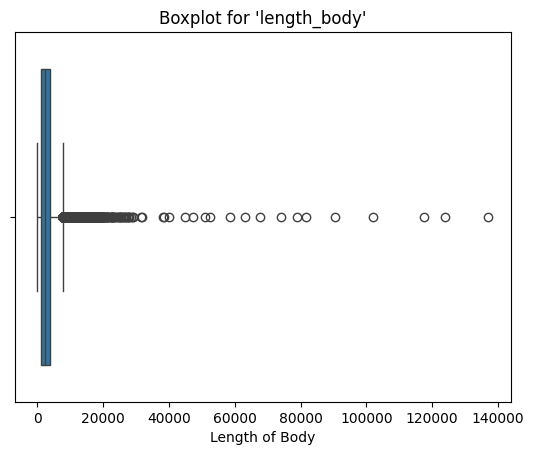

In [101]:
# Vẽ boxplot cho cột 'length_body'
sns.boxplot(x=df_en_count_keywords_upadate['length_body'])

# Thêm tiêu đề và nhãn
plt.title("Boxplot for 'length_body'")
plt.xlabel("Length of Body")

# Hiển thị biểu đồ
plt.show()

Lọc các bài báo có số từ trong body lớn hơn phân vị thứ 25

In [112]:
df_en_count_keywords_upadate1 = df_en_count_keywords_upadate[df_en_count_keywords_upadate['length_body'] >=  int(df_en_count_keywords_upadate['length_body'].quantile(0.5))]

In [120]:
df_en_count_keywords_upadate1.sort_values('length_body')

,paper_id,title,abstract,body_text,publish_time,doi,length_body,length_abstract,relatate_covid,relatate_pademic,relatate_infection,sum_relatate_keyword
78167,b2ddb3a0a3cf3388b97b889fad2470196e805116,Relation of Cardiovascular Risk Factors to Mor...,Individuals with established cardiovascular di...,Coronavirus disease 2019 caused by severe acut...,2021-02-01,10.1016/j.amjcard.2021.01.029,2458,252,22,2,8,32
263000,d3b9ae67a69939ab44edb61ddd36faff8be8028b,Living the Magnet culture,Read about how one nursing team utilized Magne...,Leadership during the COVID-19 pandemic G loba...,2021-11-29,10.1097/01.numa.0000792016.93450.50,2458,25,12,20,3,35
106702,3cf842979d659c22c5d4407e9baf9d07e176e9ed,Respiratory mechanics and gas exchanges in the...,Rationale: COVID-19 ARDS could differ from typ...,Patients with Covid-19 pneumonia fulfilling Be...,2020-07-16,10.1186/s13613-020-00716-1,2458,262,20,0,3,23
47352,ead6c3e38fa2cf6d885fb81b7260f62a389bbf7d,0123456789) 1 3 Journal of Racial and Ethnic H...,Disparities in morbidity and mortality related...,Disparities in the USA based on race and ethni...,2021-11-08,10.1007/s40615-021-01175-5,2458,275,24,2,3,29
123411,e6ece0a802c6d2d9bf04ce47772e658acc84ac74,Industry and workplace characteristics associa...,Background: To combat coronavirus disease 2019...,A number of countries have used digital contac...,2021-09-21,10.1186/s12199-021-01016-1,2458,268,21,3,8,32
...,...,...,...,...,...,...,...,...,...,...,...,...
77955,bd163b03e7b63545701ee4842f648e9cecef3b22,CLINICAL STUDY PROTOCOL Protocol Title: A Phase 3,"BACKGROUND: At interim analysis in a phase 3, ...",PROTOCOL SUMMARY\nProtocol Number: mRNA-1273-P...,2021-09-22,10.1056/nejmoa2113017,90515,372,1046,20,261,1327
311816,ff5409bd620fe1fceeb7f31959e78906a347f09d,Efficacy and Safety of NVX-CoV2373 in Adults i...,"BACKGROUND: NVX-CoV2373 is an adjuvanted, reco...",. OR Severe COVID- 19: ute at rest. . SpO2 2/F...,2021-12-15,10.1056/nejmoa2116185,102150,348,818,23,137,978
219190,5585d3e92e7d80de9c67f755a8934e34a92ac846,Janssen Vaccines & Prevention B.V.* Clinical P...,BACKGROUND: The Ad26.COV2.S vaccine is a recom...,To evaluate the efficacy of Ad26.COV2.S in the...,2021-04-21,10.1056/nejmoa2101544,117531,357,1252,8,362,1622
154590,3f93e488c15b4863f12742a184abe1e157c35244,CLINICAL STUDY PROTOCOL Protocol Title: A Phase 3,BACKGROUND: The highly transmissible severe ac...,1. To provide a 50 µg booster dose (BD) of mRN...,2022-01-25,10.1101/2022.01.24.22269666,124062,255,959,23,270,1252


#### Lưu csv bản lọc cuối cùng

In [121]:
df_en_count_keywords_upadate1.to_csv('./CSV/news_data_final.csv', index=False)

# __4. Trực quan hoá dữ liệu__

In [3]:
news_data = pd.read_csv('./CSV/news_data_final.csv')

## 1. Tổng số bài báo liên quan đến covid theo năm
- __Biểu đồ cột:__ Số lượng bài báo theo từng năm/tháng
- __Ý nghĩa:__ Xu hướng xuất bản các bài báo về COVID-19 theo thời gian.

In [4]:
news_data['publish_time'] = pd.to_datetime(news_data['publish_time'], errors='coerce')

In [5]:
papers_by_year = news_data['publish_time'].dt.year.value_counts().sort_index()
papers_by_year

publish_time
2019       14
2020    23808
2021    43917
2022    17117
Name: count, dtype: int64

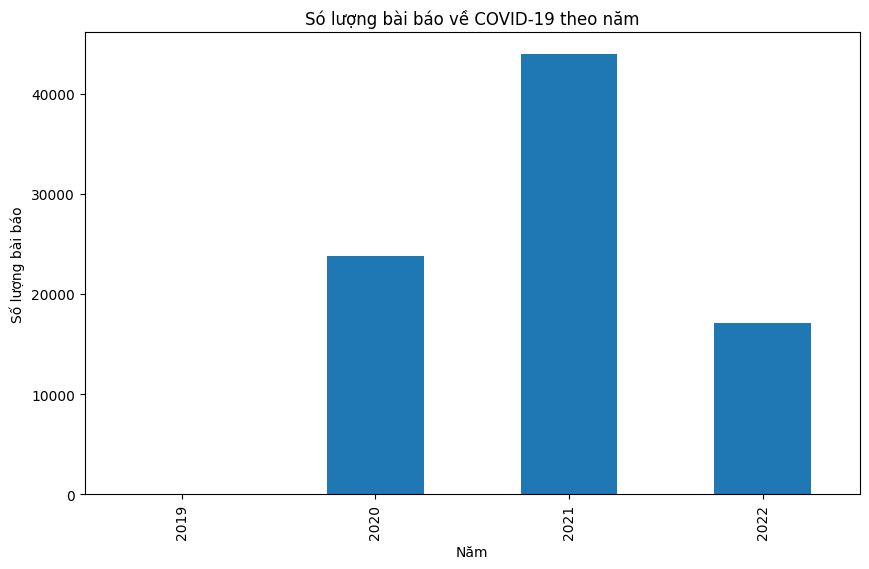

In [7]:
plt.figure(figsize=(10, 6))
papers_by_year.plot(kind='bar')
plt.title('Só lượng bài báo về COVID-19 theo năm')
plt.xlabel('Năm')
plt.ylabel('Số lượng bài báo')
plt.show()

## 2. Phân tích tần suất từ khoá tổng thể
- __Biểu đồ cột ngang:__ Tần suất xuất hiện của các từ khoá
- __Ý nghĩa:__ Xác định từ khoá nào phổ biến trong bộ dữ liệu

In [10]:
keywords = ['relatate_covid', 'relatate_pademic', 'relatate_infection']
keyword_counts = news_data[keywords].sum()
keyword_counts

relatate_covid        3908387
relatate_pademic       893357
relatate_infection    1626404
dtype: int64

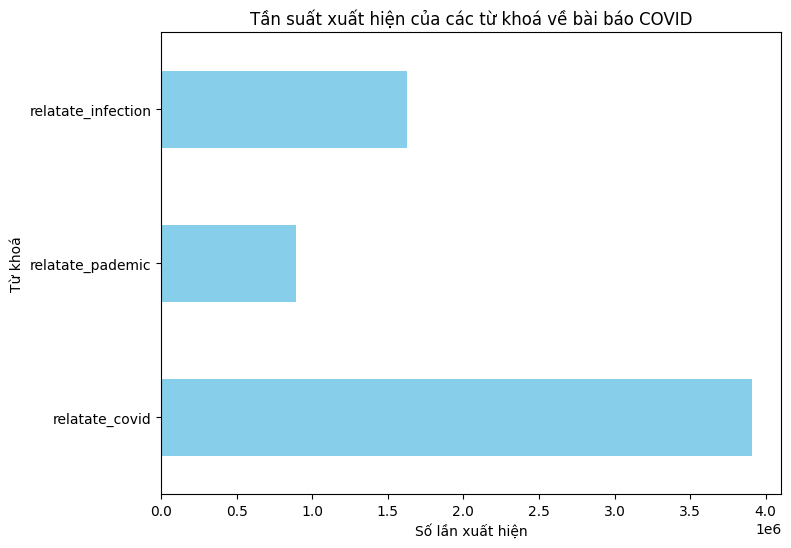

In [11]:
plt.figure(figsize=(8, 6))
keyword_counts.plot(kind='barh', color='skyblue')
plt.title('Tần suất xuất hiện của các từ khoá về bài báo COVID')
plt.xlabel('Số lần xuất hiện')
plt.ylabel('Từ khoá')
plt.show()

## 3. Xu hướng từ khoá theo thời gian
- __Biểu đồ đường:__ số lần xuất hiện của từng từ khoá theo thời gian.
- __Ý nghĩa:__ Theo dõi mức đô quan tâm đến các từ khoá trong các giai đoạn khác nhau.

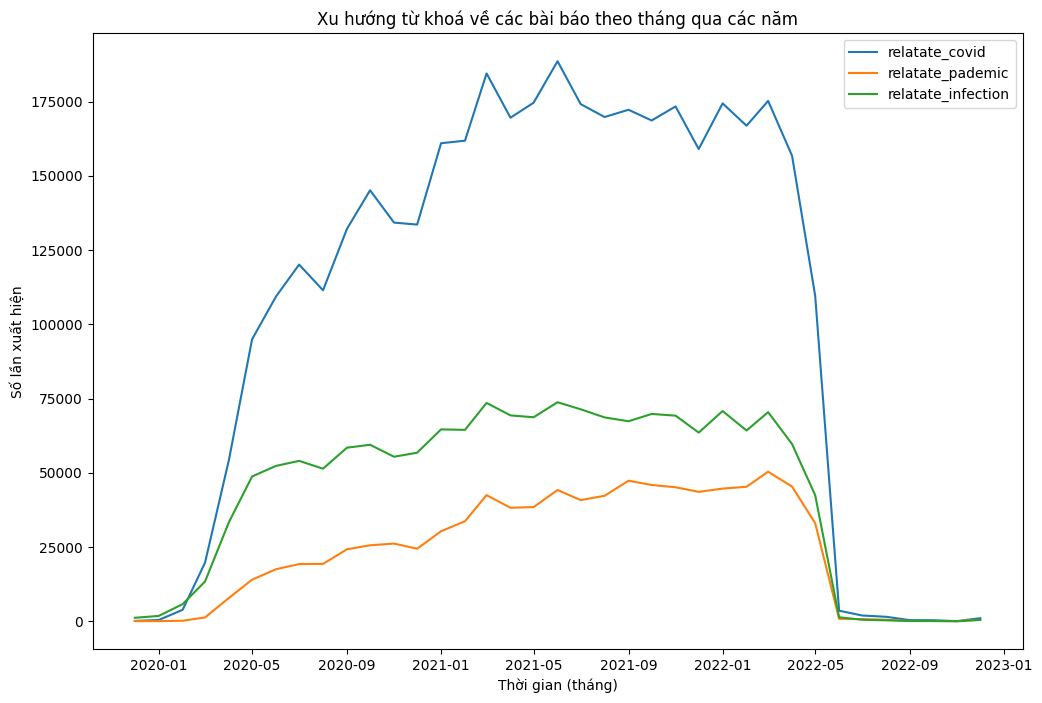

In [ ]:
keywords = ['relatate_covid', 'relatate_pademic', 'relatate_infection']

news_data1 = news_data.copy()
news_data1['year_month'] = news_data['publish_time'].dt.to_period('M')
trend_by_month1 = news_data1.groupby(news_data1['year_month'])[keywords].sum()
trend_by_month1.index = trend_by_month1.index.to_timestamp()

plt.figure(figsize=(12, 8))
for keyword in keywords:
    plt.plot(trend_by_month1.index, trend_by_month1[keyword], label=keyword)

plt.title('Xu hướng từ khoá về các bài báo theo tháng qua các năm')
plt.xlabel('Thời gian (tháng)')
plt.ylabel('Số lần xuất hiện')
plt.legend()

#### Thêm từ khoá mới - Các từ bên trong của chủ đề COVID

In [16]:
new_keywords = ['fatality', 'fatalities', 'death', 'deaths', 'died', 'mortality', 'case', 'cases', 'confirmed case', 'positive case', 'diagnosed case', 'diagnosed cases', 'vaccine', 'vaccines', 'vaccination', 'vaccinations', 'vaccinated','variant', 'variants']
news_data_new_keywords = news_data.copy()
news_data_new_keywords = count_keywords_parallel(news_data_new_keywords, new_keywords)

Counting keywords: 100%|██████████| 84856/84856 [03:09<00:00, 448.64it/s]  


In [17]:
news_data_new_keywords['relate_case'] = news_data_new_keywords[['case', 'cases', 'confirmed case', 'positive case', 'diagnosed case', 'diagnosed cases']].sum(axis=1)
news_data_new_keywords['relate_death'] = news_data_new_keywords[['fatality', 'fatalities', 'death', 'deaths', 'died', 'mortality']].sum(axis=1)
news_data_new_keywords['relate_vaccine'] = news_data_new_keywords[['vaccine', 'vaccines', 'vaccination', 'vaccinations', 'vaccinated']].sum(axis=1)
news_data_new_keywords['relate_variant'] = news_data_new_keywords[['variant', 'variants']].sum(axis=1)

In [ ]:
news_data_new_keywords.drop(['doi', 'length_abstract', 'length_body',  'relatate_covid', 'relatate_pademic', 'relatate_infection', 'sum_relatate_keyword'], axis=1, inplace=True)
news_data_new_keywords.drop([key for key in new_keywords], axis=1, inplace=True)

In [26]:
news_data_new_keywords.to_csv('./CSV/addition_keyword_data.csv', index=False)

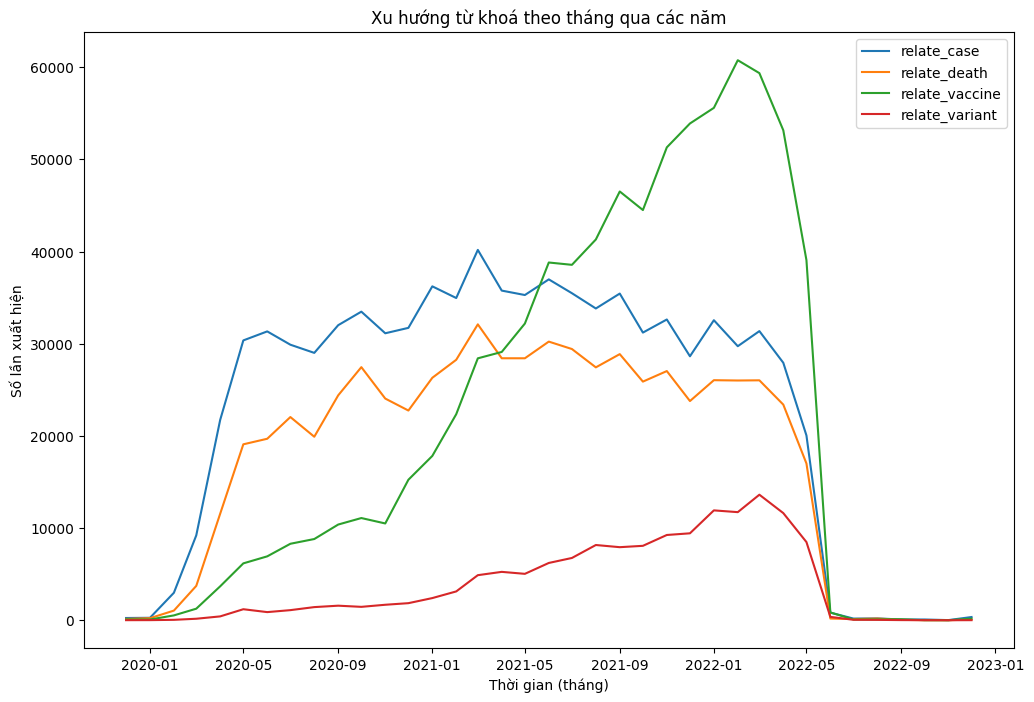

In [27]:
keywords = ['relate_case', 'relate_death', 'relate_vaccine', 'relate_variant']
news_data_new_keywords1 = news_data_new_keywords.copy()
news_data_new_keywords1['year_month'] = news_data_new_keywords1['publish_time'].dt.to_period('M')
trend_by_month_ = news_data_new_keywords1.groupby(news_data_new_keywords1['year_month'])[keywords].sum()
trend_by_month_.index = trend_by_month_.index.to_timestamp()

plt.figure(figsize=(12, 8))
for keyword in keywords:
    plt.plot(trend_by_month_.index, trend_by_month_[keyword], label=keyword)

plt.title('Xu hướng từ khoá theo tháng qua các năm')
plt.xlabel('Thời gian (tháng)')
plt.ylabel('Số lần xuất hiện')
plt.legend()
plt.show()

#### Các loại biến chủng covid

In [28]:
covid_variant_keywords = ['alpha','beta','gamma','delta','omicron','epsilon','zeta','eta','theta','iota','kappa','lambda','mu']
news_data_covid_variant_keywords = news_data.copy()
news_data_covid_variant_keywords = count_keywords_parallel(news_data_covid_variant_keywords, covid_variant_keywords)

Counting keywords: 100%|██████████| 84856/84856 [02:38<00:00, 535.24it/s]  


In [31]:
news_data_covid_variant_keywords.to_csv('./CSV/variants_data.csv', index=False)

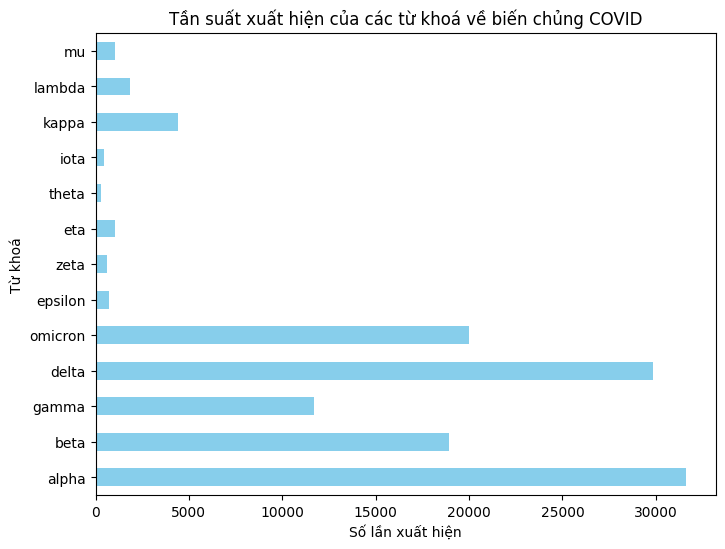

In [15]:
news_data_covid_variant_keyword_counts = news_data_covid_variant_keywords[covid_variant_keywords].sum()
plt.figure(figsize=(8, 6))
news_data_covid_variant_keyword_counts.plot(kind='barh', color='skyblue')
plt.title('Tần suất xuất hiện của các từ khoá về biến chủng COVID')
plt.xlabel('Số lần xuất hiện')
plt.ylabel('Từ khoá')
plt.show()

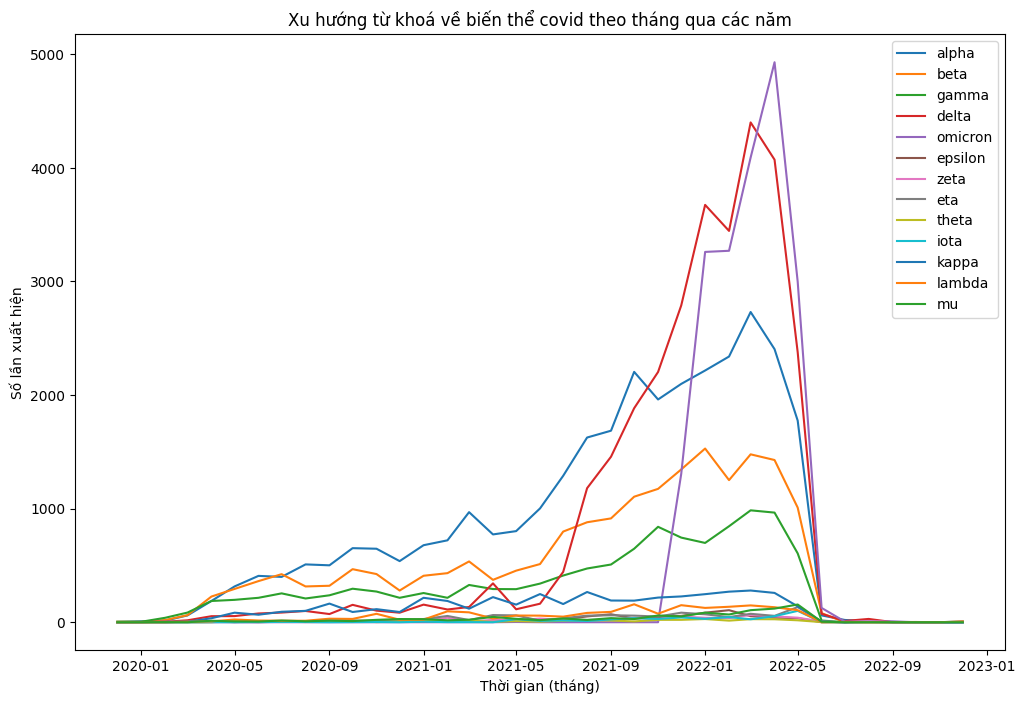

In [16]:
covid_variant_keywords = ['alpha','beta','gamma','delta','omicron','epsilon','zeta','eta','theta','iota','kappa','lambda','mu']
news_data_covid_variant_keywords1 = news_data_covid_variant_keywords.copy()
news_data_covid_variant_keywords1['year_month'] = news_data_covid_variant_keywords1['publish_time'].dt.to_period('M')
trend_by_month_ = news_data_covid_variant_keywords1.groupby(news_data_covid_variant_keywords1['year_month'])[covid_variant_keywords].sum()
trend_by_month_.index = trend_by_month_.index.to_timestamp()

plt.figure(figsize=(12, 8))
for keyword in covid_variant_keywords:
    plt.plot(trend_by_month_.index, trend_by_month_[keyword], label=keyword)

plt.title('Xu hướng từ khoá về biến thể covid theo tháng qua các năm')
plt.xlabel('Thời gian (tháng)')
plt.ylabel('Số lần xuất hiện')
plt.legend()
plt.show()